In [85]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
import numpy as np
import pandas as pd

In [86]:
from pathlib import Path
import sys 
CWD = Path.cwd().resolve()
project_root = Path.cwd().parents[3]
sys.path.append(str(project_root))
from src.utils.common.isotope import *
from parameters.parameters_materials import *
from src.utils.pre_processing.pre_processing import *
from src.utils.post_preocessing.post_processing import *
from parameters.parameters_paths import PATH_TO_CROSS_SECTIONS
os.environ["OPENMC_CROSS_SECTIONS"] = PATH_TO_CROSS_SECTIONS

In [87]:
material = openmc.Materials([FUEL_UO2_MATERIAL, AIR_MATERIAL, PYC_EXTERNAL_MATERIAL, 
                             PYC_INTERNAL_MATERIAL, SIC_MATERIAL, WATER_MATERIAL])
material.export_to_xml()

In [88]:
RADIUS_FUEL = 0.025  # 250 microns in cm
THICKNESS_PYC_INTERNAL = 0.0065  # 65 microns in cm
THICKNESS_SIC = 0.00175  # 17.5 microns in cm
THICKNESS_PYC_EXTERNAL = 0.00175  # 17.5 microns in cm

TOTAL_RADIUS = RADIUS_FUEL + THICKNESS_PYC_INTERNAL + THICKNESS_SIC + THICKNESS_PYC_EXTERNAL
RADIUS_CALCULATION = 0.02

In [89]:
# 250 microns in cm
r_pin_fuel = openmc.Sphere(r=RADIUS_FUEL, boundary_type='transmission')
fuel_cell = openmc.Cell(fill=FUEL_UO2_MATERIAL, region=-r_pin_fuel)

r_pin_pyc = openmc.Sphere(r=RADIUS_FUEL + THICKNESS_PYC_INTERNAL, boundary_type='transmission')
pyc_cell = openmc.Cell(fill=PYC_INTERNAL_MATERIAL, region=-r_pin_pyc & +r_pin_fuel)

r_pin_sic = openmc.Sphere(r=RADIUS_FUEL + THICKNESS_PYC_INTERNAL + THICKNESS_SIC, boundary_type='transmission')
sic_cell = openmc.Cell(fill=SIC_MATERIAL, region=-r_pin_sic & +r_pin_pyc)

r_pin_pyc_external = openmc.Sphere(r=TOTAL_RADIUS, boundary_type='transmission')
pyc_external_cell = openmc.Cell(fill=PYC_EXTERNAL_MATERIAL, region=-r_pin_pyc_external & +r_pin_sic)

# calculation spheres for tally regions
calculation_sphere_1 = openmc.Sphere(x0=TOTAL_RADIUS + RADIUS_CALCULATION + 0.03, r=RADIUS_CALCULATION, boundary_type='transmission') 
calculation_cell_1 = openmc.Cell(fill=AIR_MATERIAL, region=-calculation_sphere_1)

calculation_sphere_2 = openmc.Sphere(x0=TOTAL_RADIUS + RADIUS_CALCULATION + 0.13, r=RADIUS_CALCULATION, boundary_type='transmission')
calculation_cell_2 = openmc.Cell(fill=AIR_MATERIAL, region=-calculation_sphere_2)

# i want to define a square region
# air_region = parallelepiped(xmin=-100, xmax=100, ymin=-100, ymax=100, zmin=-100, zmax=100, boundary_type='reflective', surface_id_start=50)
air_region = openmc.Sphere(r=200.0, surface_id=306, boundary_type='vacuum')
air_cell = openmc.Cell(fill=AIR_MATERIAL, region=-air_region & ~calculation_cell_1.region & ~calculation_cell_2.region & ~pyc_external_cell.region) 


/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=306.
  warn(msg, IDWarning)


AJOUTER POINTS DE CALCUL

In [90]:
geometry = openmc.Geometry([fuel_cell, pyc_cell, sic_cell, pyc_external_cell, air_cell, calculation_cell_1, calculation_cell_2])
# geometry = openmc.Geometry([fuel_cell, air_cell, calculation_cell_1, calculation_cell_2])
geometry.export_to_xml()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

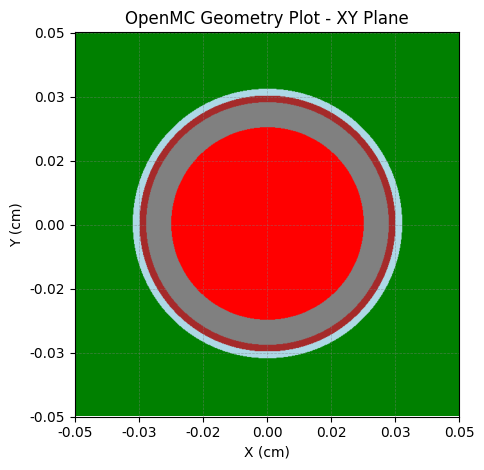

In [91]:
plot_geometry(materials = material, 
              plane="xy", width=0.1, 
              height=0.1, color_by="material",)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

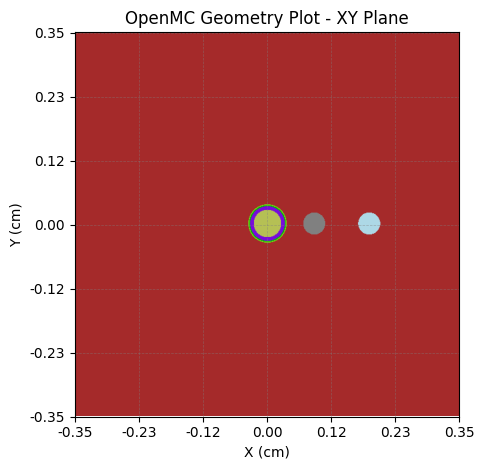

In [92]:
plot_geometry(materials = material, 
              plane="xy", width=0.7, 
              height=0.7, color_by="cell",)

In [93]:
atom_densities = FUEL_UO2_MATERIAL.get_nuclide_atom_densities()
RADIUS_FUEL = 0.025  # cm
VOLUME_FUEL = (4/3) * np.pi * RADIUS_FUEL**3  # cm^3
MASS_FUEL = FUEL_UO2_MATERIAL.density * VOLUME_FUEL  # g

masses = {nuclide: density * VOLUME_FUEL for nuclide, density in atom_densities.items()}
mass_235U = masses.get('U235', 0)
mass_238U = masses.get('U238', 0)

In [94]:
uranium_235 = Radionuclide_lara("U-235")
uranium_238 = Radionuclide_lara("U-238")
energy_235U, intensity_235U, types = uranium_235.get_rays_emission_data(photon_only=True, energy_filter=20)
energy_238U, intensity_238U, types = uranium_238.get_rays_emission_data(photon_only=True, energy_filter=20)
activity_235U = uranium_235.get_activity(mass_235U)
activity_238U = uranium_238.get_activity(mass_238U)
intensity_235U *= activity_235U
intensity_238U *= activity_238U
total_activity = activity_235U + activity_238U


In [95]:
energy_total_uranium = energy_238U
energy_total_uranium = np.append(energy_total_uranium, energy_235U)
energy_total_uranium *= 1e3
intensity_total_uranium = intensity_238U
intensity_total_uranium = np.append(intensity_total_uranium, intensity_235U)

In [96]:
energy_total_uranium

array([ 49550. ,  89954. ,  93351. , 105554. , 108968.7, 113500. ,
        31600. ,  41400. ,  42010. ,  51210. ,  54100. ,  54250. ,
        64450. ,  72700. ,  74940. ,  89954. ,  93351. ,  96090. ,
        97000. , 105554. , 108968.7, 109190. , 115450. , 120350. ,
       136550. , 140760. , 142400. , 143767. , 150936. , 163356. ,
       173000. , 182620. , 185720. , 194940. , 198894. , 202120. ,
       205316. , 215280. , 221386. , 228760. , 233500. , 240880. ,
       246830. , 255365. , 266470. , 275350. , 275490. , 281420. ,
       282940. , 289560. , 291650. , 301700. , 310690. , 317100. ,
       343500. , 345920. , 350000. , 356030. , 387840. , 390270. ,
       410290. , 448400. ])

In [97]:
source = openmc.IndependentSource(space=openmc.stats.spherical_uniform(r_inner=0, r_outer=RADIUS_FUEL, origin=(0, 0, 0)),
                                  angle=openmc.stats.Isotropic(),
                                  energy=openmc.stats.Discrete([1_800_000], [1]),
                                  strength=total_activity,
                                  particle="photon")

In [ ]:
tallies = openmc.Tallies([])

mesh_tally_xy = mesh_tally_dose_plane(plane="xy", particule_type="photon", 
                                      name_mesh_tally="flux_mesh_xy", 
                                      thickness=0.005, coord_value=0.0, 
                                      lower_left=(-TOTAL_RADIUS*2, -TOTAL_RADIUS*2), upper_right=(TOTAL_RADIUS*2, TOTAL_RADIUS*2),
                                      bin_number=250)
tallies.append(mesh_tally_xy)

# mesh_tally_yz = mesh_tally_dose_plane(plane="yz", particule_type="photon", 
#                                       name_mesh_tally="flux_mesh_yz", 
#                                       thickness=1.0, coord_value=0.0, 
#                                       bin_number=250)
# tallies.append(mesh_tally_yz)

In [99]:
tallies.export_to_xml()

In [100]:
energy_235U

array([ 31.6   ,  41.4   ,  42.01  ,  51.21  ,  54.1   ,  54.25  ,
        64.45  ,  72.7   ,  74.94  ,  89.954 ,  93.351 ,  96.09  ,
        97.    , 105.554 , 108.9687, 109.19  , 115.45  , 120.35  ,
       136.55  , 140.76  , 142.4   , 143.767 , 150.936 , 163.356 ,
       173.    , 182.62  , 185.72  , 194.94  , 198.894 , 202.12  ,
       205.316 , 215.28  , 221.386 , 228.76  , 233.5   , 240.88  ,
       246.83  , 255.365 , 266.47  , 275.35  , 275.49  , 281.42  ,
       282.94  , 289.56  , 291.65  , 301.7   , 310.69  , 317.1   ,
       343.5   , 345.92  , 350.    , 356.03  , 387.84  , 390.27  ,
       410.29  , 448.4   ])

In [101]:
intensity_total_uranium

array([1.11645785e-05, 1.74596709e-07, 2.88324840e-07, 1.00913694e-07,
       3.36378980e-08, 2.78714012e-06, 4.30738345e-06, 7.34788942e-06,
       1.41890278e-05, 8.61476691e-06, 2.91381822e-07, 7.22120167e-06,
       4.56075895e-06, 2.93915577e-05, 1.29221504e-05, 9.02016770e-04,
       1.45690911e-03, 2.30571703e-05, 4.05400796e-06, 5.19419769e-04,
       1.74829093e-04, 4.20603325e-04, 7.60126492e-06, 6.58776293e-06,
       3.04050597e-06, 5.06750995e-05, 1.29221504e-06, 2.77192794e-03,
       2.28037948e-05, 1.28714753e-03, 1.52025298e-06, 9.88164439e-05,
       1.44424033e-02, 1.59626563e-04, 9.12151790e-06, 2.73645537e-04,
       1.27194500e-03, 7.34788942e-06, 2.98983087e-05, 1.87497868e-06,
       9.62826890e-06, 1.87497868e-05, 1.39356524e-05, 1.87497868e-06,
       1.97632888e-06, 1.29221504e-05, 8.10801591e-06, 1.59626563e-06,
       1.59626563e-06, 1.87497868e-06, 1.01350199e-05, 1.34289014e-06,
       2.38172967e-06, 2.78713047e-07, 8.10801591e-07, 1.01350199e-05,
      

In [102]:
settings = openmc.Settings()
batches_number = 50
settings.batches = batches_number
settings.particles = 10**5
settings.source = source
settings.uniform_source_sampling = True
settings.photon_transport = True
settings.run_mode = "fixed source"
settings.verbose = True
settings.export_to_xml()

In [103]:
remove_previous_results(batches_number)
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [104]:
sp = openmc.StatePoint(f"statepoint.{batches_number}.h5")

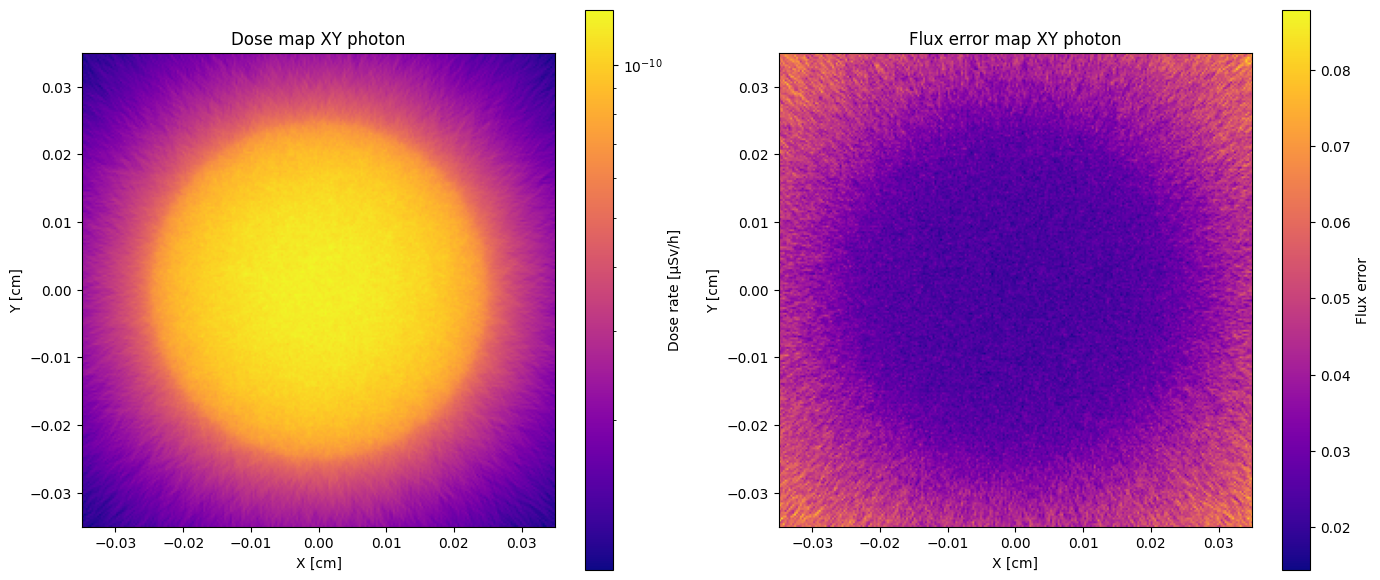

In [ ]:
load_mesh_tally_dose(statepoint_file=sp, cwd = CWD, name_mesh_tally="flux_mesh_xy", particule_type="photon",
                plane = "xy", upper_right=(TOTAL_RADIUS*2, TOTAL_RADIUS*2), lower_left=(-TOTAL_RADIUS*2, -TOTAL_RADIUS*2), bin_number=250,
                zoom_x=(-TOTAL_RADIUS*2, TOTAL_RADIUS*2), zoom_y=(-TOTAL_RADIUS*2, TOTAL_RADIUS*2), saving_figure=False, plot_error=True)